In [28]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import gzip
import os
import tempfile

import numpy as np
# from six.moves import urllib
# from six.moves import xrange  # pylint: disable=redefined-builtin


import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist
from tensorflow.contrib import rnn


import math
import random
import time
import datetime


from collections import *


%matplotlib inline    
# import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.ticker import FuncFormatter

import IPython
from IPython.display import display

# import sys
# sys.path.append("./cnn-text-classification-tf-master/" )


# http://www.cs.cornell.edu/people/pabo/movie-review-data/

# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/
# 3_NeuralNetworks/multilayer_perceptron.ipynb
    

In [30]:
# prepare datasets 
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# common parameters for validation phase
n_samples= 256


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [43]:
# training and testing data investigation

def onehot_toLabel(tup):
    for i in range(len(tup)):
        if tup[i] != 0:
            return i

train_y= map(onehot_toLabel,mnist.train.labels)

train_ycnter = dict(Counter(train_y))

In [6]:
#  MLP for MNIST

learning_rate = 0.005
batch_size = 512
display_step = 1
beta=0.01 # regularization
keep_prob=0.5


# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)


# network
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

w1= tf.Variable(tf.truncated_normal([n_input, n_hidden_1],\
                                                 stddev=math.sqrt(2.0/float(n_input))),\
                             name='weights1')
b1 = tf.Variable(  tf.random_normal([n_hidden_1]), name='biases1'   )
h1= tf.nn.relu( tf.add( tf.matmul(x, w1),b1 ) )


w2= tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],\
                                                 stddev=math.sqrt(2.0/float(n_hidden_1))),\
                             name='weights2')
b2 = tf.Variable(  tf.random_normal([n_hidden_2]), name='biases2'   )
h2= tf.nn.relu( tf.add( tf.matmul(h1, w2),b2 ) )
# regularization
# h2_out= tf.nn.dropout(h2, keep_prob)


w_o= tf.Variable(tf.truncated_normal([n_hidden_2, n_classes],\
                                                 stddev=math.sqrt(2.0/float(n_hidden_2))),\
                             name='weights_o')
b_o= tf.Variable(  tf.random_normal([n_classes]), name='biases_o'   )
logis_o=  tf.add( tf.matmul(h2, w_o), b_o) 


# cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logis_o, labels=y) )
#                      + beta*tf.nn.l2_loss(w_o) )

# inference
correct_prediction = tf.equal(tf.argmax(logis_o, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# operations 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()


In [ ]:
#  MLP for MNIST

n_epoch=30
train_acc=[]
test_acc=[]

with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(n_epoch):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        
#         print "epoch loss: ", avg_cost 
        
        train_acc.append( accuracy.eval({x: mnist.train.images[:n_samples],\
                                         y: mnist.train.labels[:n_samples]}))
        test_acc.append(  accuracy.eval({x: mnist.test.images[:n_samples], \
                                         y: mnist.test.labels[:n_samples]} ))
    
    print "Optimization Finished!"


# plot training and testing accuracy w.r.t epoches



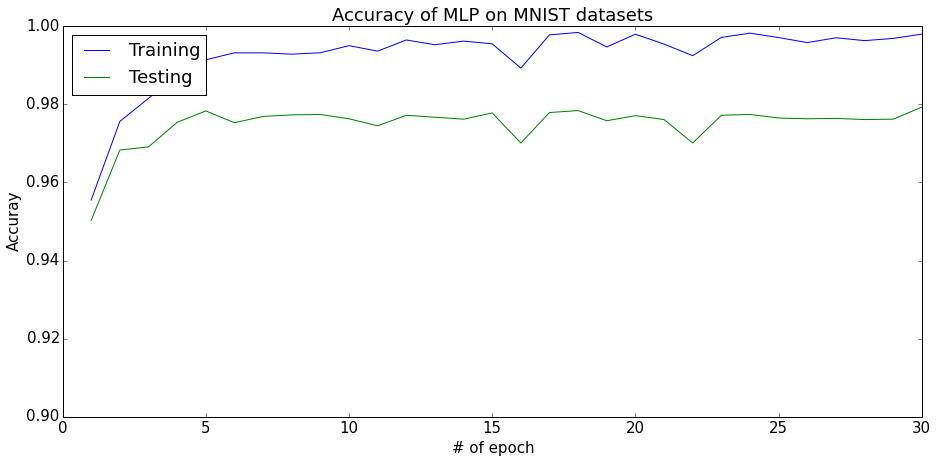

In [67]:
#  MLP for MNIST
fig = plt.figure()
    
figsize=( 15.4,7)
font_size=15
fig.set_size_inches( figsize )
fig_title="Accuracy of MLP on MNIST datasets"
matplotlib.rcParams.update({'font.size': font_size})

axes = plt.gca()
axes.set_ylim([0.9,1.0])
    
x= range(1,n_epoch+1)
plt.plot( x, train_acc ,label='Training' )
plt.plot( x, test_acc ,label='Testing' )

plt.title(fig_title)
plt.ylabel('Accuray')
plt.xlabel('# of epoch')
plt.legend(loc='upper left')

fig.savefig('results/test_batch512.jpg', format='jpg', bbox_inches='tight')


In [33]:
#  MLP Encapsulation for MNIST

class mlp_mnist():
    
    def __init__(self, layers_size_list, batch_size,input_size, n_class,session,\
                 lr=0.003):
        
        self.LEARNING_RATE = lr
        self.BATCH_SIZE = batch_size
        self.N_LAYERS = len(layers_size_list)
        
        self.INPUT_SIZE = input_size
        self.N_CLASS = n_class
        
        self.sess=session
        self.x = tf.placeholder(tf.float32, [None, self.INPUT_SIZE])
        self.y = tf.placeholder(tf.float32, [None, self.N_CLASS])
        
        
#       build multi-layer FCN 
        with tf.variable_scope("layer"+str(0)):
            w= tf.Variable(tf.random_normal([self.INPUT_SIZE, layers_size_list[0]],\
                                        stddev=math.sqrt(2.0/float(self.INPUT_SIZE)))) 
                
            b= tf.Variable(tf.zeros( [layers_size_list[0]] ))
                
#                 w=tf.get_variable('w', shape=[self.INPUT_SIZE, layers_size_list[0]],\
#                       initializer=tf.random_normal_initializer(0, \
#                                                 math.sqrt(2.0/float(input_size))))
                
#                 b = tf.get_variable('b', shape=[layers_size_list[0]],\
#                       initializer=tf.constant_initializer(0.0) )
        
            h= tf.nn.relu( tf.add( tf.matmul(self.x, w),b) )
        
        for i in range(1, self.N_LAYERS):
            
            with tf.variable_scope("layer"+str(i)):
                
                w= tf.Variable(tf.random_normal([layers_size_list[i-1],layers_size_list[i]],\
                                stddev=math.sqrt(2.0/float(layers_size_list[i-1])))) 
                
                b= tf.Variable(tf.zeros( [layers_size_list[i]] ))
                
                h = tf.nn.relu( tf.add( tf.matmul(h, w),b) )
        
        
        
        with tf.variable_scope("output"):
            
            w= tf.Variable(tf.random_normal([layers_size_list[self.N_LAYERS-1],self.N_CLASS],\
                        stddev=math.sqrt(2.0/float(layers_size_list[self.N_LAYERS-1])))) 
                
            b= tf.Variable(tf.zeros( [ self.N_CLASS ] ))
            
            h = tf.add( tf.matmul(h, w),b)
            
            self.logit = h

        
#   initialize loss and optimization operations for training
    def train_ini(self):
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
                                                    logits=self.logit, labels=self.y) )
        
        self.optimizer = \
        tf.train.AdamOptimizer(learning_rate=self.LEARNING_RATE).minimize(self.cost)
        self.init = tf.global_variables_initializer()
        sess.run( self.init )
        
#   training on batch of data
    def train_batch(self, x_batch, y_batch):
        
        _,c = sess.run([self.optimizer,self.cost],\
                       feed_dict={self.x : x_batch,self.y : y_batch})
        
        return c
    
#   initialize inference         
    def inference_ini(self):
        
        self.correct_prediction = tf.equal(tf.argmax(self.logit,1), tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
        
#   infer givn testing data    
    def inference(self, x_test,y_test):
        return sess.run([self.accuracy], feed_dict={self.x : x_test,self.y : y_test} )


In [37]:
#  MLP Encapsulation for MNIST

para_n_epoch=50
para_layer_size=[ 128,128 ]
para_batch_size=128
para_n_class=10
para_input_size= 28*28


with tf.Session() as sess:
    
    mlp_clf = mlp_mnist( para_layer_size, para_batch_size , para_input_size , \
                         para_n_class , sess ,lr=0.001 )
    
    mlp_clf.train_ini()
    
    # Training cycle
    for epoch in range(para_n_epoch):
        
        total_batch = int(mnist.train.num_examples/para_batch_size)
        # Loop over all batches
        
        tmpc=0.0
        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(para_batch_size)
            
            tmpc += mlp_clf.train_batch( batch_x, batch_y)
        
        tmp_acc = mlp_clf.inference(mnist.test.images,mnist.test.labels)  
        
        print "loss on epoch ", epoch, " : ", 1.0*tmpc/total_batch, tmp_acc
    
    print "Optimization Finished!"


In [4]:
# CNN for MNIST

learning_rate = 0.005

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units
beta=0.01 # regularization

n_c1=16
n_c2=32


# Variable
# initialization methods

# Orthogonal initilization


# He's initilization
# wc1 = tf.Variable(tf.random_normal([5,5,1,n_c1],stddev=math.sqrt(2.0/float(n_input))))
# wc2 = tf.Variable(tf.random_normal([5,5,n_c1,n_c2],stddev=math.sqrt(2.0/float(n_c1)))) 
# w1 = tf.Variable(tf.random_normal([7*7*n_c2,1024],stddev=math.sqrt(2.0/float(n_c2))))
# wo = tf.Variable(tf.random_normal([1024, n_classes],stddev=math.sqrt(2.0/float(1024)))))


# xavier initilization
wc1 = tf.get_variable('wcon1',shape=[5,5,1,n_c1],\
                      initializer=tf.contrib.layers.xavier_initializer() )
wc2 = tf.get_variable('wcon2',shape=[5,5,n_c1,n_c2],\
                      initializer=tf.contrib.layers.xavier_initializer() )
w1 = tf.get_variable('w1',shape=[7*7*n_c2,1024],\
                     initializer=tf.contrib.layers.xavier_initializer() )
wo = tf.get_variable('wo', shape=[1024, n_classes],\
                     initializer=tf.contrib.layers.xavier_initializer() )


# bc1 = tf.Variable( tf.random_normal([n_c1]) )
# bc2 = tf.Variable( tf.random_normal([n_c2]) )
# b1 = tf.Variable( tf.random_normal([1024]) )
# bo = tf.Variable( tf.random_normal([n_classes]) )

bc1 = tf.Variable( tf.zeros([n_c1]) )
bc2 = tf.Variable( tf.zeros([n_c2]) )
b1 = tf.Variable( tf.zeros([1024]) )
bo = tf.Variable( tf.zeros([n_classes]) )


# Nextwork
fx = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

x = tf.reshape(fx, shape=[-1, 28, 28, 1])

c1 = tf.nn.conv2d(x, wc1, strides=[1,1,1,1], padding='SAME')
c1 =tf.nn.relu(tf.nn.bias_add(c1, bc1) )
c1 = tf.nn.max_pool( c1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME' )

c2 = tf.nn.conv2d( c1, wc2, strides=[1,1,1,1],padding='SAME')
c2 = tf.nn.relu(tf.nn.bias_add(c2, bc2) )
c2 = tf.nn.max_pool( c2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME' )

c2 = tf.reshape( c2, shape=[-1, w1.get_shape().as_list()[0]  ] )
# h1 = tf.nn.relu( tf.add(tf.matmul(c2, w1), b1) )
h1 = tf.nn.relu( tf.matmul(c2, w1)+ b1 )

# regularization
# h1= tf.nn.dropout(h1, dropout)

h2 = tf.matmul( h1, wo) + bo
logit=h2

# inference
corr_pred = tf.equal( tf.argmax(logit, 1), tf.argmax(y,1) )
accuracy  = tf.reduce_mean( tf.cast(corr_pred, tf.float32) ) 

# cost
cost = tf.reduce_mean(  tf.nn.softmax_cross_entropy_with_logits(logits= logit, labels=y))

# opertions
opti = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
ini= tf.global_variables_initializer()


In [ ]:
# Multilayer CNN for MNIST



In [1]:
# CNN for MNIST

batch_size = 100
n_epoch=30
train_acc=[]
test_acc=[]

with tf.Session() as sess:
    sess.run(ini)

    for epoch in range(n_epoch):        
        
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
#             _, c = sess.run([opti,cost], feed_dict={fx: batch_x,
#                                                           y: batch_y, keep_prob: dropout})
            
            sess.run(opti,feed_dict={fx: batch_x,y: batch_y, keep_prob: dropout})
            
            # Compute average loss
#             avg_cost += c / total_batch
        
#         print "epoch loss: ", avg_cost
         
        print "epoch: ", epoch
        
        
        train_acc.append( accuracy.eval({fx: mnist.train.images[:n_samples],\
                                          y: mnist.train.labels[:n_samples],\
                                          keep_prob:1.0}))
        test_acc.append(  accuracy.eval({fx: mnist.test.images[:n_samples],\
                                          y: mnist.test.labels[:n_samples],\
                                          keep_prob:1.0}))
        
#         print cost.eval( feed_dict={fx: batch_x,y: batch_y, keep_prob: dropout})
    
    
#     accuracy.eval({fx: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob:1.0})
    
#         train_acc.append( accuracy.eval({fx: mnist.train.images, y: mnist.train.labels,\
#                                          keep_prob:1.0}))
#         test_acc.append(  accuracy.eval({fx: mnist.test.images,  y: mnist.test.labels,\
#                                          keep_prob:1.0}))
        
    print "Optimization Finished!"


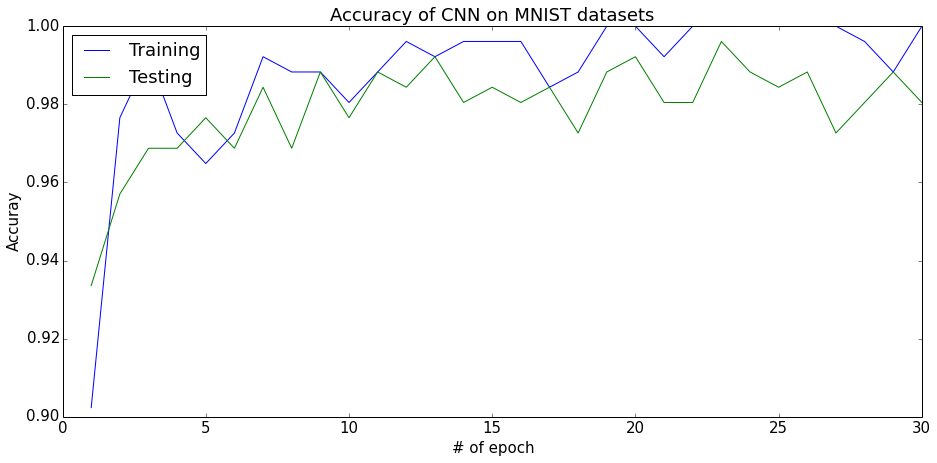

In [8]:
#  CNN for MNIST
fig = plt.figure()
    
figsize=( 15.4,7)
font_size=15
fig.set_size_inches( figsize )
fig_title="Accuracy of CNN on MNIST datasets"
matplotlib.rcParams.update({'font.size': font_size})

axes = plt.gca()
axes.set_ylim([0.9,1.0])
    
x= range(1,n_epoch+1)
plt.plot( x, train_acc ,label='Training' )
plt.plot( x, test_acc ,label='Testing' )

plt.title(fig_title)
plt.ylabel('Accuray')
plt.xlabel('# of epoch')
plt.legend(loc='upper left')

fig.savefig('results/cnn_lr0.01.jpg', format='jpg', bbox_inches='tight')


In [3]:
# LSTM for MNIST

# Parameters
learning_rate = 0.001
n_rnn_layers=1
batch_size = 100


# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 64 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# variables
fx = tf.placeholder(tf.float32, [None, n_steps, n_input])
y  = tf.placeholder(tf.float32, [None, n_classes])

wo= tf.Variable( tf.random_normal([n_hidden,n_classes], stddev=math.sqrt(2.0/n_hidden)))
bo= tf.Variable( tf.random_normal( [n_classes] ))

wa= tf.Variable( tf.random_normal([n_hidden,1], stddev=math.sqrt(2.0/n_hidden)))
ba= tf.Variable( tf.random_normal([n_steps] ))

x= tf.transpose(fx, [1,0,2] )
x= tf.reshape(x, [-1, n_input])
x= tf.split(x, n_steps,0)

# network
## lstm_cell=rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_cell=rnn.LSTMCell(n_hidden, forget_bias=1.0)
stacked_lstm= rnn.MultiRNNCell([lstm_cell]*n_rnn_layers, state_is_tuple=True )
hiddens, cells= rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)

## attention
tmp_hiddens= tf.transpose(hiddens, [1,0,2])
tmp_hiddens= tf.reshape(tmp_hiddens, [-1,n_hidden])

tmpmat= tf.reshape(tf.matmul(tmp_hiddens, wa), [-1, n_steps])
tmpmat= tf.nn.relu(tf.add(tmpmat, ba))
att_wei= tf.nn.softmax(tmpmat, -1)
att_wei= tf.expand_dims(att_wei, -1)

tmp_hiddens= tf.transpose(hiddens, [1,2,0])
att_hiddens=[]
for i in range(batch_size):
    att_hiddens.append( tf.matmul( tmp_hiddens[i],att_wei[i] ) )
      
att_hiddens= tf.stack(att_hiddens)
att_hiddens= tf.squeeze(att_hiddens)
    

output_logit= tf.add(tf.matmul( att_hiddens, wo ), bo)
# output_logit= tf.add(tf.matmul( hiddens[-1], wo ), bo)

# cost
cost= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logit, labels=y))
correct_pred= tf.equal(  tf.argmax(output_logit,1),  tf.argmax(y,1) )
accuracy=tf.reduce_mean( tf.cast( correct_pred, tf.float32 ))

# operations
opti=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
ini= tf.global_variables_initializer()


In [ ]:
# LSTM for MNIST

batch_size = 100
n_epoch=1
train_acc=[]
test_acc=[]

with tf.Session() as sess:
    
    sess.run(ini)
    
    for epoch in range(n_epoch):        
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x.reshape((batch_size, n_steps, n_input))

            sess.run(opti,feed_dict={fx:batch_x, y:batch_y})
            
#       test attention          
#         print att_wei.eval(feed_dict={fx:batch_x[:5], y:batch_y[:5]})
            
#             # Compute average loss
# #             avg_cost += c / total_batch
        
        print "epoch: ", epoch
        
#         train_acc.append( accuracy.eval({\
#                         fx: mnist.train.images[:n_samples].reshape((-1, n_steps, n_input)),\
#                                           y: mnist.train.labels[:n_samples]}))
#         test_acc.append(  accuracy.eval({\
#                         fx: mnist.test.images[:n_samples].reshape((-1, n_steps, n_input)),\
#                                           y: mnist.test.labels[:n_samples],}))
        
    print "Optimization Finished!"


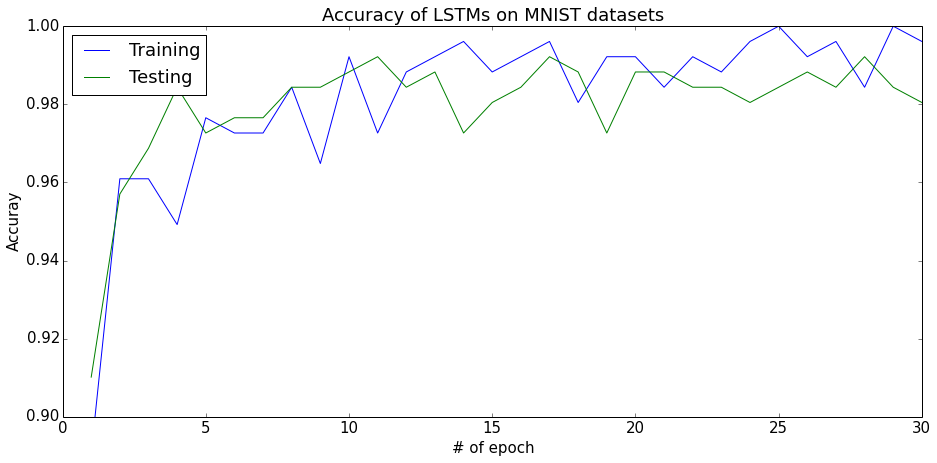

In [5]:
#  LSTM for MNIST
fig = plt.figure()
    
figsize=(15.4,7)
font_size=15
fig.set_size_inches( figsize )
fig_title="Accuracy of LSTMs on MNIST datasets"
matplotlib.rcParams.update({'font.size': font_size})

axes = plt.gca()
axes.set_ylim([0.9,1.0])
    
x= range(1,n_epoch+1)
plt.plot( x, train_acc ,label='Training' )
plt.plot( x, test_acc ,label='Testing' )

plt.title(fig_title)
plt.ylabel('Accuray')
plt.xlabel('# of epoch')
plt.legend(loc='upper left')

# fig.savefig('results/cnn_lr0.01.jpg', format='jpg', bbox_inches='tight')


In [5]:
# cascade of CNN and LSTM 

# Parameters
learning_rate = 0.001
n_rnn_layers=1
batch_size = 100


# Network Parameters
n_image=28*28
n_c1=16
n_c2=32

n_dim = 7*7 # MNIST data input (img shape: 28*28)
n_steps = n_c2 # timesteps
n_hidden = 64 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# variables
raw_x = tf.placeholder(tf.float32, [None, n_image])
y  = tf.placeholder(tf.float32, [None, n_classes])

# xavier initilization
wc1= tf.Variable( tf.random_normal([5,5,1,n_c1], stddev=math.sqrt(2.0/n_image)))
wc2= tf.Variable( tf.random_normal([5,5,n_c1,n_c2], stddev=math.sqrt(2.0/n_c1)))

bc1 = tf.Variable( tf.zeros([n_c1]) )
bc2 = tf.Variable( tf.zeros([n_c2]) )

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

wo= tf.Variable( tf.random_normal([n_hidden,n_classes], stddev=math.sqrt(2.0/n_hidden)))
bo= tf.Variable( tf.random_normal( [n_classes] ))

# for attention
wa= tf.Variable( tf.random_normal([n_hidden,1], stddev=math.sqrt(2.0/n_hidden)))
ba= tf.Variable( tf.random_normal([n_steps] ))


# cnn
x = tf.reshape(raw_x, shape=[-1, 28, 28, 1])

c1 = tf.nn.conv2d(x, wc1, strides=[1,1,1,1], padding='SAME')
c1 =tf.nn.relu(tf.nn.bias_add(c1, bc1) )
c1 = tf.nn.max_pool( c1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME' )

c2 = tf.nn.conv2d( c1, wc2, strides=[1,1,1,1],padding='SAME')
c2 = tf.nn.relu(tf.nn.bias_add(c2, bc2) )
c2 = tf.nn.max_pool( c2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME' )


# lstm
tmpseq = tf.transpose(c2, [0,3,1,2])
tmpseq = tf.reshape(tmpseq, [-1, n_steps, n_dim ])

lstm_x= tf.transpose(tmpseq, [1,0,2] )
lstm_x= tf.reshape(lstm_x, [-1, n_dim])
lstm_x= tf.split(lstm_x, n_steps,0)

## lstm_cell=rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_cell=rnn.LSTMCell(n_hidden, forget_bias=1.0)
stacked_lstm= rnn.MultiRNNCell([lstm_cell]*n_rnn_layers, state_is_tuple=True )
hiddens, cells= rnn.static_rnn(stacked_lstm, lstm_x, dtype=tf.float32)

## --- self-attention ---
# tmp_hiddens= tf.transpose(hiddens, [1,0,2])
# tmp_hiddens= tf.reshape(tmp_hiddens, [-1,n_hidden])

# tmpmat= tf.reshape(tf.matmul(tmp_hiddens, wa), [-1, n_steps])
# tmpmat= tf.nn.relu(tf.add(tmpmat, ba))
# att_wei= tf.nn.softmax(tmpmat, -1)
# att_wei= tf.expand_dims(att_wei, -1)

# tmp_hiddens= tf.transpose(hiddens, [1,2,0])
# att_hiddens=[]
# for i in range(batch_size):
#     att_hiddens.append( tf.matmul( tmp_hiddens[i],att_wei[i] ) )
      
# att_hiddens= tf.stack(att_hiddens)
# att_hiddens= tf.squeeze(att_hiddens)
# ---                ---

# output_logit= tf.add(tf.matmul( att_hiddens, wo ), bo)
output_logit= tf.add(tf.matmul( hiddens[-1], wo ), bo)

# cost
cost= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logit, labels=y))
correct_pred= tf.equal(  tf.argmax(output_logit,1),  tf.argmax(y,1) )
accuracy=tf.reduce_mean( tf.cast( correct_pred, tf.float32 ))

# operations
opti=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
ini= tf.global_variables_initializer()


In [7]:
# cascade of CNN and LSTM for MNIST

batch_size = 100
n_epoch=1
train_acc=[]
test_acc=[]

with tf.Session() as sess:
    
    sess.run(ini)
    
#     batch_x, batch_y = mnist.train.next_batch(batch_size)
#     print tmpshape.eval( feed_dict = {raw_x:batch_x, y:batch_y} )
    
    for epoch in range(n_epoch):        
#         avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            
            sess.run(opti,feed_dict={raw_x:batch_x, y:batch_y})            
        
        print "epoch: ", epoch
        
#         train_acc.append( accuracy.eval({\
#                         fx: mnist.train.images[:n_samples].reshape((-1, n_steps, n_input)),\
#                                           y: mnist.train.labels[:n_samples]}))
#         test_acc.append(  accuracy.eval({\
#                         fx: mnist.test.images[:n_samples].reshape((-1, n_steps, n_input)),\
#                                           y: mnist.test.labels[:n_samples],}))
        
    print "Optimization Finished!"


epoch:  0
Optimization Finished!


<matplotlib.colorbar.Colorbar instance at 0x7f21bbd21dd0>

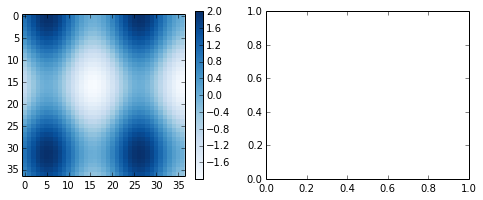

In [23]:
# setup some generic data
N = 37
x, y = np.mgrid[:N, :N]
Z = (np.cos(x*0.2) + np.sin(y*0.3))

# mask out the negative and positve values, respectively
Zpos = np.ma.masked_less(Z, 0)
Zneg = np.ma.masked_greater(Z, 0)

fig, (ax1, ax2) = plt.subplots(figsize=(8, 3), ncols=2)

# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(Z, cmap='Blues', interpolation='none')

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
fig.colorbar(pos, ax=ax1)

# repeat everything above for the the negative data
# neg = ax2.imshow(Zneg, cmap='Reds_r', interpolation='none')
# fig.colorbar(neg, ax=ax2)

plt.show()

In [51]:
# character-level text generation [keras]
# http://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

filename = "../dataset/dataset_text/wonderland"
raw_text = open(filename).read()
raw_text = raw_text.lower()


chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))


n_chars = len(raw_text)
n_vocab = len(chars)
print "Total Characters: ", n_chars
print "Total Vocab: ", n_vocab


seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print "Total Patterns: ", n_patterns


dataX, X_test, dataY, y_test = train_test_split(dataX, dataY, test_size=0.95, random_state=42)
n_patterns = len(dataX)
print "Selected Patterns: ", len(dataX),len(dataY)


# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)


# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_dim=X.shape[1]))
#  input_shape=(X.shape[1], X.shape[2])
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, \
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]


model.fit(X, y, nb_epoch=20, batch_size=128, callbacks=callbacks_list)

In [36]:
# character-level text generation [keras]
#  generate text by using trained model

# load the network weights
filename = "weights-improvement-19-2.6820.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

int_to_char = dict((i, c) for i, c in enumerate(chars))

# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print "Seed:"
print "\"", ''.join([int_to_char[value] for value in pattern]), "\""

# # generate characters
for i in range(100):    
    
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
#     seq_in = [int_to_char[value] for value in pattern]
#     sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
    
print "\nDone."


print ''.join( [int_to_char[value] for value in pattern] )

Seed:
" ter folding his arms and frowning at the cook till his eyes were
nearly out of sight, he said in a d "

Done.
o thet  an  ao  ao  a  a  a                                                                         


In [2]:
# world-level text generation [TensorFlow]

# https://github.com/spiglerg/RNN_Text_Generation_Tensorflow

class ModelNetwork:
    
    def __init__(self, in_size, lstm_size, num_layers, out_size, session,\
                 learning_rate=0.003, name="rnn"):
        
        self.scope = name
        self.in_size = in_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.out_size = out_size

        self.session = session

        self.learning_rate = tf.constant( learning_rate )
        
        # Last state of LSTM, used when running the network in TEST mode
        
        self.lstm_last_state = np.zeros((self.num_layers*2*self.lstm_size,))
        
        with tf.variable_scope(self.scope):
            
            ## (batch_size, timesteps, in_size)
            self.xinput = tf.placeholder(tf.float32, shape=(None, None, self.in_size),\
#                                          name="xinput"
                                        )
            self.lstm_init_value = tf.placeholder(tf.float32, shape=(None, \
                                                self.num_layers*2*self.lstm_size),\
#                                                   name="lstm_init_value"
                                                 )
            
            # LSTM
            self.lstm_cells = [ tf.contrib.rnn.BasicLSTMCell(self.lstm_size, \
                                                             forget_bias=1.0,\
                            state_is_tuple=False) for i in range(self.num_layers)]
            self.lstm = tf.contrib.rnn.MultiRNNCell(self.lstm_cells, state_is_tuple=False)
            
            # Iteratively compute output of recurrent network
            outputs, self.lstm_new_state = tf.nn.dynamic_rnn(self.lstm, self.xinput,\
                                initial_state=self.lstm_init_value, dtype=tf.float32)
            
            # Linear activation (FC layer on top of the LSTM net)
            self.rnn_out_W = tf.Variable(tf.random_normal( (self.lstm_size, self.out_size),\
                                                          stddev=0.01 ))
            self.rnn_out_B = tf.Variable(tf.random_normal( (self.out_size, ), stddev=0.01 ))
            
            outputs_reshaped = tf.reshape( outputs, [-1, self.lstm_size] )
            network_output = ( tf.matmul( outputs_reshaped, self.rnn_out_W )\
                              + self.rnn_out_B )
            
            batch_time_shape = tf.shape(outputs)
            self.final_outputs = tf.reshape( tf.nn.softmax( network_output),\
                                (batch_time_shape[0],batch_time_shape[1],self.out_size) )

            ## Training: provide target outputs for supervised training.

            self.y_batch = tf.placeholder(tf.float32, (None, None, self.out_size))
            y_batch_long = tf.reshape(self.y_batch, [-1, self.out_size])

            self.cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(\
                                                                logits=network_output,\
                                                                labels=y_batch_long) )
            self.train_op = \
            tf.train.RMSPropOptimizer(self.learning_rate, 0.9).minimize(self.cost)


            
    ## Input: X is a single element, not a list!
    def run_step(self, x, init_zero_state=True):
        ## Reset the initial state of the network.
        if init_zero_state:
            init_value = np.zeros((self.num_layers*2*self.lstm_size,))
            
        else:
            init_value = self.lstm_last_state

        out, next_lstm_state = self.session.run([self.final_outputs, self.lstm_new_state],\
                        feed_dict={self.xinput:[x], self.lstm_init_value:[init_value]   } )
        
        self.lstm_last_state = next_lstm_state[0]
        
        return out[0][0]



    ## xbatch must be (batch_size, timesteps, input_size)
    ## ybatch must be (batch_size, timesteps, output_size)

    def train_batch(self, xbatch, ybatch):
        init_value = np.zeros((xbatch.shape[0], self.num_layers*2*self.lstm_size))
        cost, _ = self.session.run([self.cost, self.train_op],\
                                   feed_dict={self.xinput:xbatch,\
                            self.y_batch:ybatch, self.lstm_init_value:init_value   } )
        
        return cost



In [47]:
# world-level text generation [TensorFlow]

data_ = ""
with open('../dataset/dataset_text/shakespeare', 'r') as f:
    data_ += f.read()
data_ = data_.lower()

char_set = list(set(data_))

words=data_.split()
voca=list(set(words))
print "word and vocabulary size:", len(words), len(voca)

word_int= dict( [ (w,i) for i, w in enumerate(voca)] )
int_word= dict( [ (i,w) for i, w in enumerate(voca)] )

word and vocabulary size: 202651 23641


In [4]:
# world-level text generation [TensorFlow]

# Embed string to character-arrays -- it generates an array len(data) x len(vocab)
# Vocab is a list of elements

# %reset

def embed_to_vocab(data_, vocab):
    
    data = np.zeros((len(data_), len(vocab)))
    cnt=0

    for s in data_:
        v = [0.0]*len(vocab)
        v[vocab.index(s)] = 1.0
        data[cnt, :] = v
        cnt += 1
    return data

def decode_embed(array, vocab):
    return vocab[ array.index(1) ]


ckpt_file = ""
TEST_PREFIX = "The " # Prefix to prompt the network in test mode

# print "Usage:"
# print '\t\t ', sys.argv[0], ' [ckpt model to load] [prefix, e.g., "The "]'
# if len(sys.argv)>=2:
#     ckpt_file=sys.argv[1]
# if len(sys.argv)==3:
#     TEST_PREFIX = sys.argv[2]

## Load the data
data_ = ""
with open('../dataset/dataset_text/shakespeare', 'r') as f:
    data_ += f.read()
data_ = data_.lower()

## Convert to 1-hot coding
vocab = list(set(data_))

data = embed_to_vocab(data_, vocab)


in_size = out_size = len(vocab)
lstm_size = 256 #128
num_layers = 2
batch_size = 64 #128
time_steps = 100 #50

NUM_TRAIN_BATCHES = 20000

LEN_TEST_TEXT = 500 # Number of test characters of text to generate after training the network



## Initialize the network
config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

net = ModelNetwork(in_size = in_size,
					lstm_size = lstm_size,
					num_layers = num_layers,
					out_size = out_size,
					session = sess,
					learning_rate = 0.003,
					name = "char_rnn_network")

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver(tf.global_variables())



## 1) TRAIN THE NETWORK
if ckpt_file == "":
	last_time = time.time()

	batch = np.zeros((batch_size, time_steps, in_size))
	batch_y = np.zeros((batch_size, time_steps, in_size))

	possible_batch_ids = range(data.shape[0]-time_steps-1)
	for i in range(NUM_TRAIN_BATCHES):
		# Sample time_steps consecutive samples from the dataset text file
		batch_id = random.sample( possible_batch_ids, batch_size )

		for j in range(time_steps):
			ind1 = [k+j for k in batch_id]
			ind2 = [k+j+1 for k in batch_id]

			batch[:, j, :] = data[ind1, :]
			batch_y[:, j, :] = data[ind2, :]


		cst = net.train_batch(batch, batch_y)

		if (i%100) == 0:
			new_time = time.time()
			diff = new_time - last_time
			last_time = new_time

			print "batch: ",i,"   loss: ",cst,"   speed: ",(100.0/diff)," batches / s"

	saver.save(sess, "saved/model.ckpt")

In [ ]:
# world-level text generation [TensorFlow]

## 2) GENERATE LEN_TEST_TEXT CHARACTERS USING THE TRAINED NETWORK

ckpt_file = "saved/model.ckpt"
saver.restore(sess, ckpt_file)

TEST_PREFIX = TEST_PREFIX.lower()
for i in range(len(TEST_PREFIX)):
	out = net.run_step( embed_to_vocab(TEST_PREFIX[i], vocab) , i==0)

print "SENTENCE:"
gen_str = TEST_PREFIX
for i in range(LEN_TEST_TEXT):
	element = np.random.choice( range(len(vocab)), p=out ) # Sample character from the network according to the generated output probabilities
	gen_str += vocab[element]

	out = net.run_step( embed_to_vocab(vocab[element], vocab) , False )
print gen_str